# Connecting to Database


In [0]:
import sys
from google.cloud import storage
import pandas as pd
from datetime import date, datetime
from google.colab import files
import io


uploaded = files.upload()
gcs_client = storage.Client.from_service_account_json(list(uploaded.keys())[0])

Saving other_account.json to other_account (1).json


In [0]:
import pandas as pd
# had to be renamed io -> input_output due to namespace clash that stopped pycharm from working

from dateutil import parser


def get_batch_indices(gcs_client, date=None):
   """
   :param gcs_client:
   :return:
   """
   financials_bucket = gcs_client.get_bucket('plural-financials')

   if date is None:
       # If no date, we find the last one
       blobs = financials_bucket.list_blobs(prefix='dates/')
       date = max([parser.parse(blob.name.replace('dates/', '')) for blob in blobs])

   training_indices = [
       int(blob.name.split('/')[-1].replace('.pkl', ''))
       for blob in financials_bucket.list_blobs(prefix='{year}-{month}-{day}/training/'.format(
           year=date.year,
           month=date.month,
           day=date.day
       ))
   ]

   validation_indices = [
       int(blob.name.split('/')[-1].replace('.pkl', ''))
       for blob in financials_bucket.list_blobs(prefix='{year}-{month}-{day}/validation/'.format(
           year=date.year,
           month=date.month,
           day=date.day
       ))
   ]

   return date, sorted(training_indices), sorted(validation_indices)


def download_batch_to_file(gcs_client, date, batch_index, batch_type, local_path):
   """
   :param gcs_client:
   :param date:
   :param batch_index:
   :param batch_type:
   :param local_path:
   :return:
   """
   financials_bucket = gcs_client.get_bucket('plural-financials')

   blob = financials_bucket.blob('{year}-{month}-{day}/{batch_type}/{batch_index}.pkl'.format(
       year=date.year,
       month=date.month,
       day=date.day,
       batch_type=batch_type,
       batch_index=batch_index
   ))
   file_object = open(local_path, "wb+")
   blob.download_to_file(file_object)


def get_batch_dataset(gcs_client, date, batch_index, batch_type):
   """
   :param date:
   :param batch_index:
   :param batch:
   :param batch_type:
   :return:
   """
   filename = '/tmp/dataset.pkl'

   download_batch_to_file(gcs_client, date, batch_index, batch_type, filename)

   with open(filename, 'rb') as f:
       dataset = pd.read_pickle(f, compression=None)

   return dataset

# Preprocessing Training Set

## Download Data


In [0]:
# import sys

# #sys.path.append(‘/home/jupyter/msc-thesis/code’)
# from google.cloud import storage
# import pandas as pd
# from datetime import date, datetime

# gcs_client = storage.Client.from_service_account_json('/Users/xueyanmei/other_account.json')
train_dataset_container = []
flag = True
batch_index = 0
date, training_indices, validation_indices = get_batch_indices(gcs_client, date=None)
while flag and batch_index < 6000:
  try:
    dataset = get_batch_dataset(gcs_client, date, batch_index=batch_index, batch_type='training')
    train_dataset_container.append(dataset)
    print(batch_index)
  except:
    flag = False
  batch_index += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
train_dataset = pd.concat(train_dataset_container).reset_index(drop=True)

In [0]:
from google.colab import drive
drive.mount("drive", force_remount=True)

train_dataset.to_csv('raw_training_dataset.csv')
!cp raw_training_dataset.csv drive/My\ Drive

Mounted at drive


## Load Data

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/My\ Drive/xueyan/raw_training_dataset.csv raw_training_dataset.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

train_dataset = pd.read_csv('raw_training_dataset.csv')

## Process missing data

In [0]:
def filter_label_not_nan(df):
  return df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, subset=['IncomeStatement-TurnoverRevenue'])

def data_preprocess(df, threshold=30, mean=np.array([None, None]), std=np.array([None, None])):
  df = filter_label_not_nan(df)
  df = df.iloc[:, 1:-3]
  df = df.dropna(axis=0, thresh=threshold)
  if mean.all() == None:
    mean = df.mean()
  if std.all() == None:
    std = df.std()
  df = (df - mean) / std
  return df, mean.rename('mean'), std.rename('std')

In [0]:
preprocess_train_data, mean, std = data_preprocess(train_dataset, threshold=29)

In [0]:
preprocess_train_data

,BalanceSheet-CashBankOnHand,BalanceSheet-Creditors-CurrentFinancialInstruments,BalanceSheet-Creditors-Non-currentFinancialInstruments,BalanceSheet-CurrentAssets,BalanceSheet-Debtors,BalanceSheet-Debtors-CurrentFinancialInstruments,BalanceSheet-Equity,BalanceSheet-Equity-RetainedEarningsAccumulatedLosses,BalanceSheet-Equity-ShareCapital,BalanceSheet-FixedAssets,BalanceSheet-IntangibleAssets,BalanceSheet-InvestmentsFixedAssets,BalanceSheet-NetAssetsLiabilities,BalanceSheet-NetCurrentAssetsLiabilities,BalanceSheet-PropertyPlantEquipment,BalanceSheet-ProvisionsForLiabilitiesBalanceSheetSubtotal,BalanceSheet-TotalAssetsLessCurrentLiabilities,BalanceSheet-TotalInventories,CashFlowStatement-DividendsPaidToOwnersParentClassifiedAsFinancingActivities,CashFlowStatement-IncreaseDecreaseInCashCashEquivalentsBeforeForeignExchangeDifferencesChangesInConsolidation,CashFlowStatement-InterestReceivedClassifiedAsInvestingActivities,CashFlowStatement-NetCashFlowsFromUsedInFinancingActivities,CashFlowStatement-NetCashFlowsFromUsedInInvestingActivities,CashFlowStatement-NetCashFlowsFromUsedInOperatingActivities,CashFlowStatement-NetCashGeneratedFromOperations,CashFlowStatement-PurchasePropertyPlantEquipment,IncomeStatement-AdministrativeExpenses,IncomeStatement-CostSales,IncomeStatement-GrossProfitLoss,IncomeStatement-InterestPayableSimilarChargesFinanceCosts,IncomeStatement-OperatingProfitLoss,IncomeStatement-OtherInterestReceivableSimilarIncomeFinanceIncome,IncomeStatement-OtherOperatingIncome,IncomeStatement-ProfitLoss,IncomeStatement-ProfitLossOnOrdinaryActivitiesBeforeTax,IncomeStatement-TaxTaxCreditOnProfitOrLossOnOrdinaryActivities,IncomeStatement-TurnoverRevenue
48,0.070908,-0.152649,NaN,-0.697822,-0.711442,-0.744920,-0.399921,-0.691050,0.884259,-0.534259,-0.385743,NaN,-0.541739,-0.180643,-0.617482,0.403583,-0.528270,NaN,NaN,-0.871050,NaN,-1.225345,0.322726,0.551308,0.598551,0.455615,-0.137019,-0.137934,-0.345194,0.784613,0.635936,-0.385258,-0.213361,0.637751,0.550233,0.100602,-0.952470
206,-0.561751,-0.939118,0.107419,-0.180916,-0.688787,-0.722448,-0.289581,-0.308614,-0.211417,NaN,NaN,NaN,-0.441849,-0.171104,-0.360129,0.180453,-0.383886,0.814889,NaN,-0.086263,NaN,-0.513817,1.013623,-0.297540,-0.259537,0.125223,-0.668014,-1.097638,-0.322077,-0.964220,-0.234066,-0.212633,-0.000892,-0.284642,-0.323961,-0.181249,0.245359
207,-0.561751,-0.939118,0.107419,-0.180916,-0.688787,-0.722448,-0.289581,-0.308614,-0.211417,NaN,NaN,NaN,-0.441849,-0.171104,-0.360129,0.180453,-0.383886,0.814889,NaN,-0.086263,NaN,-0.513817,1.013623,-0.297540,-0.259537,0.125223,-0.668014,-1.097638,-0.322077,-0.964220,-0.234066,-0.212633,-0.000892,-0.284642,-0.323961,-0.181249,0.245359
4253,-0.028456,-0.783780,NaN,-0.228387,NaN,0.079877,-0.255182,-0.288982,-0.182270,-0.515022,-0.371125,-0.236050,-0.410708,-0.049603,-0.591762,0.337002,-0.444185,NaN,NaN,0.115026,-0.340907,NaN,0.260941,-0.284725,NaN,0.388005,-0.741415,-0.511173,-0.124331,NaN,-0.063075,-0.317833,NaN,0.086473,-0.035738,0.209716,-0.427491
6533,-0.575722,-0.262838,0.223029,-1.030046,-0.858192,-0.890484,-0.677167,-0.688550,-0.203363,-0.533514,-0.385710,NaN,-0.792727,-0.485795,-0.616295,NaN,-0.684436,-0.548757,NaN,-0.015308,NaN,0.137848,0.309116,-0.399529,-0.488373,0.455044,NaN,NaN,NaN,-0.099452,-0.383054,-0.385258,NaN,-0.312311,-0.359880,-0.108993,-1.123855
6536,-0.575722,-0.262838,0.223029,-1.030046,-0.858192,-0.890484,-0.677167,-0.688550,-0.203363,-0.533514,-0.385710,NaN,-0.792727,-0.485795,-0.616295,NaN,-0.684436,-0.548757,NaN,-0.015308,NaN,0.137848,0.309116,-0.399529,-0.488373,0.455044,NaN,NaN,NaN,-0.099452,-0.383054,-0.385258,NaN,-0.312311,-0.359880,-0.108993,-1.123855
6547,-0.436932,0.171604,NaN,-0.732190,-0.454385,-0.489940,-0.524528,-0.546843,-0.174965,-0.361923,0.000636,0.130702,NaN,-0.609205,-0.616972,NaN,-0.598499,NaN,NaN,0.132380,NaN,NaN,-0.195907,0.086255,0.003985,0.455615,-0.128101,0.115886,-0.829860,-0.098749,-0.349295,-0.374398,-0.197526,-0.290483,-0.325682,-0.010802,-0.785173
6550,-0.436932,0.171604

In [0]:
from google.colab import drive
drive.mount("drive", force_remount=True)

FILE_NAME = 'training_dataset_thres_29.csv'
preprocess_train_data.to_csv(FILE_NAME)
!cp $FILE_NAME drive/My\ Drive/xueyan

Mounted at drive


# Preprocessing Validation Set

## Download Data

In [0]:
validation_dataset_container = []
flag = True
batch_index = 0
date, training_indices, validation_indices = get_batch_indices(gcs_client, date=None)
while flag and batch_index < 6000:
  try:
    dataset = get_batch_dataset(gcs_client, date, batch_index=batch_index, batch_type='validation')
    validation_dataset_container.append(dataset)
    print(batch_index)
  except:
    flag = False
  batch_index += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
validation_dataset = pd.concat(validation_dataset_container).reset_index(drop=True)

In [0]:
# from google.colab import drive
# drive.mount("drive", force_remount=True)

# training_dataset.to_csv('training_dataset.csv')
# !cp training_dataset.csv drive/My\ Drive/

from google.colab import drive
drive.mount("drive", force_remount=True)

validation_dataset.to_csv('raw_validation_dataset.csv')
!cp raw_validation_dataset.csv drive/My\ Drive/

Mounted at drive
cp: cannot stat 'validation_dataset.csv': No such file or directory


## Load Data

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/My\ Drive/xueyan/raw_validation_dataset.csv raw_validation_dataset.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

validate_dataset = pd.read_csv('raw_validation_dataset.csv')

## Process Missing Data

In [0]:
preprocess_validate_data, _, _ = data_preprocess(validate_dataset, threshold=29, mean=mean, std=std)

In [0]:
preprocess_validate_data

,BalanceSheet-CashBankOnHand,BalanceSheet-Creditors-CurrentFinancialInstruments,BalanceSheet-Creditors-Non-currentFinancialInstruments,BalanceSheet-CurrentAssets,BalanceSheet-Debtors,BalanceSheet-Debtors-CurrentFinancialInstruments,BalanceSheet-Equity,BalanceSheet-Equity-RetainedEarningsAccumulatedLosses,BalanceSheet-Equity-ShareCapital,BalanceSheet-FixedAssets,BalanceSheet-IntangibleAssets,BalanceSheet-InvestmentsFixedAssets,BalanceSheet-NetAssetsLiabilities,BalanceSheet-NetCurrentAssetsLiabilities,BalanceSheet-PropertyPlantEquipment,BalanceSheet-ProvisionsForLiabilitiesBalanceSheetSubtotal,BalanceSheet-TotalAssetsLessCurrentLiabilities,BalanceSheet-TotalInventories,CashFlowStatement-DividendsPaidToOwnersParentClassifiedAsFinancingActivities,CashFlowStatement-IncreaseDecreaseInCashCashEquivalentsBeforeForeignExchangeDifferencesChangesInConsolidation,CashFlowStatement-InterestReceivedClassifiedAsInvestingActivities,CashFlowStatement-NetCashFlowsFromUsedInFinancingActivities,CashFlowStatement-NetCashFlowsFromUsedInInvestingActivities,CashFlowStatement-NetCashFlowsFromUsedInOperatingActivities,CashFlowStatement-NetCashGeneratedFromOperations,CashFlowStatement-PurchasePropertyPlantEquipment,IncomeStatement-AdministrativeExpenses,IncomeStatement-CostSales,IncomeStatement-GrossProfitLoss,IncomeStatement-InterestPayableSimilarChargesFinanceCosts,IncomeStatement-OperatingProfitLoss,IncomeStatement-OtherInterestReceivableSimilarIncomeFinanceIncome,IncomeStatement-OtherOperatingIncome,IncomeStatement-ProfitLoss,IncomeStatement-ProfitLossOnOrdinaryActivitiesBeforeTax,IncomeStatement-TaxTaxCreditOnProfitOrLossOnOrdinaryActivities,IncomeStatement-TurnoverRevenue
34,-0.234973,-0.086847,NaN,0.050522,0.385113,0.342774,0.388079,0.255952,0.163804,-0.485680,NaN,-0.236243,0.171631,0.722458,-0.539776,2.055669,-0.021887,-0.190496,NaN,0.319886,NaN,0.100741,0.167458,-0.050845,-0.129931,0.262159,0.232896,0.089459,-0.117775,-0.081702,-0.025599,-0.360840,NaN,0.028968,-0.000796,0.192256,-0.597167
35,0.207993,0.019471,NaN,0.372980,0.576103,0.532220,0.670283,0.531115,0.163804,-0.492395,NaN,-0.236243,0.427108,1.019387,-0.550561,1.729086,0.124857,-0.117937,NaN,0.228831,NaN,0.141168,0.243740,-0.208017,-0.234700,0.364113,0.323446,0.142486,-0.004117,-0.093500,-0.042905,-0.313603,NaN,0.027090,-0.016094,0.096984,-0.495488
36,-0.409422,NaN,NaN,-0.076233,0.296321,NaN,-0.581948,NaN,NaN,-0.499393,-0.385743,-0.236243,0.042804,0.580246,-0.561800,1.927909,-0.106906,-0.203400,NaN,0.196408,NaN,0.125534,0.251378,-0.216305,-0.261662,0.378923,0.264509,0.108004,-0.153997,-0.040819,-0.156748,-0.385191,NaN,-0.103704,-0.139117,0.084088,-0.585195
54,-0.573631,0.376579,-0.175327,-0.499615,-0.197903,-0.235531,-0.315929,-0.411382,-0.210759,0.055531,-0.385743,NaN,-0.465701,-0.546783,0.329716,-0.052230,-0.203058,-0.314566,NaN,-0.017737,NaN,-0.075772,0.257449,-0.130675,-0.159446,0.377965,0.201641,0.235938,-0.538156,0.440484,-0.379614,NaN,0.010076,-0.373249,-0.429266,-0.199813,-0.544299
55,-0.573631,0.376579,-0.175327,-0.499615,-0.197903,-0.235531,-0.315929,-0.411382,-0.210759,0.055531,-0.385743,NaN,-0.465701,-0.546783,0.329716,-0.052230,-0.203058,-0.314566,NaN,-0.017737,NaN,-0.075772,0.257449,-0.130675,-0.159446,0.377965,0.201641,0.235938,-0.538156,0.440484,-0.379614,NaN,0.010076,-0.373249,-0.429266,-0.199813,-0.544299
56,-0.575504,NaN,NaN,-0.562949,-0.277739,NaN,-0.678311,NaN,NaN,0.142714,-0.385743,NaN,-0.397430,-0.518371,0.469730,-0.184228,-0.112571,-0.340286,NaN,-0.223947,NaN,0.191602,-0.116291,-0.243913,-0.286133,-0.165855,0.213544,0.210241,-0.468033,0.390468,-0.229281,-0.379595,0.122863,-0.228149,-0.270566,-0.029354,-0.554699
77,-0.567339,0.568779,-0.085447,-0.476080,0.015496,-0.023856,-0.503407,-0.696740,0.497988,NaN,NaN,NaN,-0.635424,-0.743258,0.184114,0.219748,-0.382939,-0.515075,NaN,0.005247,NaN,0.464318,-0.783088,0.124379,0.074566,-1.276220,0.270448,0.356161,-0.436682,0.406057,-0.328998,-0.385224,-0.027226,-0.323478,-0.373481,-0.131866,-0.362276
78,-0.567339,0.568779,-0.0854

In [0]:
FILE_NAME = 'validation_dataset_thres_29.csv'
preprocess_validate_data.to_csv(FILE_NAME)
!cp $FILE_NAME drive/My\ Drive/xueyan

# Loading Preprocessed Dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

preprocess_train_data = []
preprocess_validate_data = []

for i in range(25, 31):
  TRAIN_DATA = 'training_dataset_thres_'+str(i)+'.csv'
  !cp drive/My\ Drive/xueyan/$TRAIN_DATA $TRAIN_DATA
  VALIDATE_DATA = 'validation_dataset_thres_'+str(i)+'.csv'
  !cp drive/My\ Drive/xueyan/$VALIDATE_DATA $VALIDATE_DATA
  preprocess_train_data.append(pd.read_csv(TRAIN_DATA))
  preprocess_validate_data.append(pd.read_csv(VALIDATE_DATA))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def train_data_spilit(train_data):
  r, c = train_data.shape
  y = train_data.loc[:, ['IncomeStatement-TurnoverRevenue']].values
  X = train_data.drop(columns=['IncomeStatement-TurnoverRevenue']).values[:, 1:]
  slice_num = int(r*0.8)
  y_train, y_val = y[:slice_num], y[slice_num:]
  X_train, X_val = X[:slice_num], X[slice_num:]
  return [[X_train, y_train], [X_val, y_val]]

def data_extract(data):
  y = data.loc[:, ['IncomeStatement-TurnoverRevenue']].values
  X = data.drop(columns=['IncomeStatement-TurnoverRevenue']).values[:, 1:]
  return [X, y]

# Prediction Models

In [0]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np


class Prediction_Models(object):
  
  def __init__(self, train_data, test_data):
    self.model = None
    self.train_data = train_data
    self.test_data = test_data
    
  def __call__(self, name, hyperparams={}):
    if name == 'linear_regression':
      self.model = LinearRegression()
    elif name == 'ridge_regression':
      alpha = hyperparams.get('alpha', 1.0)
      self.model = Ridge(alpha=alpha)
    elif name == 'svr':
      C = hyperparams.get('C', 0.01)
      self.model = SVR(kernel='linear', C=C)
    elif name == 'lasso':
      alpha = hyperparams.get('alpha', 0.01)
      self.model = Lasso(alpha=0.01)
    elif name == 'gaussian_process':
      kernel = DotProduct() + WhiteKernel()
      alpha = hyperparams.get('alpha', 1.0)
      self.model = GaussianProcessRegressor(kernel=kernel,
                                            random_state=0,
                                            alpha=alpha
                                           )
    elif name == 'random_forest':
      n_estimators = hyperparams.get('n_estimators', 100)
      self.model = RandomForestRegressor(random_state=0,
                                         n_estimators=n_estimators
                                        )
    elif name == 'gradient_boosting':
      n_estimators = hyperparams.get('n_estimators', 100)
      learning_rate = hyperparams.get('learning_rate', 0.1)
      max_depth = hyperparams.get('max_depth', 10)
      subsample = hyperparams.get('subsample', 0.5)
      self.model = GradientBoostingRegressor(n_estimators=100,
                                             learning_rate=0.1,
                                             max_depth=10,
                                             random_state=0,
                                             loss='ls',
                                             subsample=0.5
                                            )
    elif name == 'mlp':
      hidden_layer_sizes = hyperparams.get('hidden_layer_sizes', (32,32,))
      alpha = hyperparams.get('alpha', 0.1)
      batch_size = hyperparams.get('batch_size', 32)
      max_iter = hyperparams.get('max_iter', int(1e5))
      learning_rate = hyperparams.get('learning_rate', 0.001)
      solver = hyperprames.get('solver', 'adam')
      n_iter_no_change = hyperparams.get('n_iter_no_change', 10)
      self.model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                alpha=alpha,
                                batch_size=batch_size,
                                max_iter=max_iter,
                                learning_rate_init=learning_rate,
                                solver=solver,
                                n_iter_no_change=n_iter_no_change
                               )
    else:
      raise RuntimeError('Please input a valid predicion model name!')

  def params_tuning(self, hyperparams, cv):
    self.params_tuner = GridSearchCV(self.model, hyperparams, cv=cv)
    X, y = self.train_data
    
    self.params_tuner.fit(X, y)
    return pd.DataFrame(self.params_tuner.cv_results_)
  
  def test(self, hyperparams):
    X, y = self.test_data
    return self.params_tuner.score(X, y)

# Mean Value Method

In [0]:
def mean_value_method(df):
  return df.fillna(value=df.mean())

In [0]:
train_mean = []
test_mean = []

for df in preprocess_train_data:
  train_mean.append(mean_value_method(df))
for df in preprocess_validate_data:
  test_mean.append(mean_value_method(df))

## Ridge Regression

In [0]:
test_data = data_extract(test_mean[4])
# X_test, y_test = test_data
# test_data = [X_test[:400], y_test[:400]]
pred_model = Prediction_Models(data_extract(train_mean[4]), test_data)
pred_model('ridge_regression')
training_results = pred_model.params_tuning(hyperparams={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]}, cv=5)

In [0]:
training_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002204,0.001195,0.001124,0.000874,1e-05,{'alpha': 1e-05},0.301437,0.502871,0.450801,0.570049,0.377954,0.440623,0.093840,6
1,0.001668,0.000174,0.000782,0.000123,0.0001,{'alpha': 0.0001},0.301437,0.502873,0.450803,0.570049,0.377957,0.440624,0.093840,5
2,0.001858,0.000179,0.000922,0.000021,0.001,{'alpha': 0.001},0.301437,0.502886,0.450817,0.570049,0.377981,0.440634,0.093839,4
3,0.001916,0.000032,0.000922,0.000017,0.01,{'alpha': 0.01},0.301437,0.503022,0.450958,0.570050,0.378216,0.440737,0.093829,3
4,0.001955,0.000043,0.000914,0.000013,0.1,{'alpha': 0.1},0.301431,0.504317,0.452357,0.570055,0.380348,0.441702,0.093754,2
5,0.001977,0.000087,0.000946,0.000038,1,{'alpha': 1.0},0.301493,0.512842,0.465249,0.569874,0.390062,0.447904,0.093996,1


In [0]:
training_results.to_csv('ridge_missing_11_mean_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('ridge_missing_11_mean_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.40106980955718124

In [0]:
ridge_mean_coef = pred_model.params_tuner.best_estimator_.coef_

## SVR

In [0]:
test_data = data_extract(test_mean[4])
# X_test, y_test = test_data
# test_data = [X_test[:400], y_test[:400]]
pred_model = Prediction_Models(data_extract(train_mean[4]), test_data)
pred_model('svr')
pred_model.params_tuning(hyperparams={'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
                                      'kernel': ['linear', 'rbf', 'sigmoid'],
                                     }, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069441,0.002814,0.011444,0.000318,1e-05,linear,"{'C': 1e-05, 'kernel': 'linear'}",-0.020844,-0.029155,-0.033810,-0.070320,-0.087982,-0.048422,0.026038,12
1,0.104393,0.001188,0.017755,0.000626,1e-05,rbf,"{'C': 1e-05, 'kernel': 'rbf'}",-0.045343,-0.046408,-0.052283,-0.093140,-0.088967,-0.065228,0.021259,16
2,0.105101,0.001659,0.017525,0.000249,1e-05,sigmoid,"{'C': 1e-05, 'kernel': 'sigmoid'}",-0.045167,-0.046413,-0.052149,-0.093097,-0.089254,-0.065216,0.021361,15
3,0.067121,0.001815,0.011254,0.000155,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.151643,0.095660,0.094591,0.080225,-0.070275,0.070369,0.074444,9
4,0.104149,0.001285,0.017922,0.000561,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",-0.041462,-0.041322,-0.047294,-0.088998,-0.084545,-0.060724,0.021423,13
5,0.104629,0.000857,0.018209,0.001283,0.0001,sigmoid,"{'C': 0.0001, 'kernel': 'sigmoid'}",-0.039948,-0.041519,-0.047600,-0.088008,-0.087120,-0.060839,0.021972,14
6,0.064372,0.000608,0.010693,0.000136,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.481957,0.335970,0.360860,0.371838,-0.036963,0.302732,0.177073,6
7,0.102783,0.000492,0.017949,0.000356,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",-0.004540,-0.002177,-0.005826,-0.047057,-0.035030,-0.018926,0.018492,10
8,0.103348,0.001373,0.017264,0.000442,0.001,sigmoid,"{'C': 0.001, 'kernel': 'sigmoid'}",0.013159,-0.002801,-0.005744,-0.041339,-0.061683,-0.019682,0.027535,11
9,0.080698,0.001100,0.010328,0.000621,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.415627,0.450358,0.503968,0.486570,0.269565,0.425218,0.083567,5


In [0]:
pred_model.test(hyperparams={})

0.735854798662122

In [0]:
svr_mean_coef = pred_model.get_best_coef()

AttributeError: ignored

## Random Forest

In [0]:
test_data = data_extract(test_mean[4])
# X_test, y_test = test_data
# test_data = [X_test[:400], y_test[:400]]
pred_model = Prediction_Models(data_extract(train_mean[4]), test_data)
pred_model('random_forest')
trainig_results = pred_model.params_tuning(hyperparams={'n_estimators': [10, 20, 40, 80]}, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

In [0]:
trainig_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.202556,0.002446,0.002481,0.000607,10,{'n_estimators': 10},0.933981,0.946935,0.936494,0.958723,0.938095,0.942846,0.009059,4
1,0.403312,0.005428,0.002975,0.000148,20,{'n_estimators': 20},0.934619,0.951684,0.950654,0.960743,0.947871,0.949114,0.008436,2
2,0.800463,0.002246,0.005242,0.000147,40,{'n_estimators': 40},0.934566,0.946650,0.952543,0.965477,0.946294,0.949106,0.010051,3
3,1.599015,0.012116,0.008767,0.000218,80,{'n_estimators': 80},0.938376,0.950112,0.955574,0.964867,0.945013,0.950788,0.009044,1


In [0]:
trainig_results.to_csv('random_forest_missing_11_mean_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('random_forest_missing_11_mean_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.9302860459982223

In [0]:
random_forest_mean_coef = pred_model.params_tuner.best_estimator_.feature_importances_

## Gradient Boosting

In [0]:
test_data = data_extract(test_mean[4])
# X_test, y_test = test_data
# test_data = [X_test[:400], y_test[:400]]
pred_model = Prediction_Models(data_extract(train_mean[4]), test_data)
pred_model('gradient_boosting')
training_results = pred_model.params_tuning(hyperparams={'n_estimators': [10, 20, 40, 80],
                                                         'max_depth': [5, 10, 15, 20]
                                                        }, 
                                                        cv=5
                                           )

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [0]:
training_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.045281,0.001736,0.000903,0.000031,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.785456,0.771456,0.778478,0.795032,0.814371,0.788959,0.014907,16
1,0.085114,0.000448,0.000969,0.000015,5,20,"{'max_depth': 5, 'n_estimators': 20}",0.920776,0.909197,0.918800,0.937053,0.938079,0.924781,0.011154,11
2,0.165567,0.001200,0.001157,0.000020,5,40,"{'max_depth': 5, 'n_estimators': 40}",0.966990,0.950594,0.965863,0.977446,0.960006,0.964180,0.008817,2
3,0.325468,0.002731,0.001542,0.000048,5,80,"{'max_depth': 5, 'n_estimators': 80}",0.971896,0.956663,0.973454,0.982735,0.957287,0.968407,0.010045,1
4,0.112064,0.001489,0.001060,0.000063,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.749670,0.798863,0.808361,0.824883,0.831247,0.802605,0.028865,15
5,0.220333,0.005297,0.001304,0.000045,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.889454,0.914723,0.927991,0.947425,0.943228,0.924564,0.021035,12
6,0.413203,0.005602,0.001738,0.000045,10,40,"{'max_depth': 10, 'n_estimators': 40}",0.952930,0.947511,0.961648,0.979339,0.952200,0.958725,0.011273,8
7,0.734026,0.013828,0.002448,0.000060,10,80,"{'max_depth': 10, 'n_estimators': 80}",0.960444,0.952211,0.957898,0.982022,0.949079,0.960331,0.011567,6
8,0.191474,0.002627,0.001162,0.000021,15,10,"{'max_depth': 15, 'n_estimators': 10}",0.799216,0.797945,0.792990,0.833910,0.851049,0.815022,0.023158,13
9,0.370725,0.001313,0.001589,0.000086,15,20,"{'max_depth': 15, 'n_estimators': 20}",0.929661,0.914143,0.914086,0.948326,0.944726,0.930188,0.014542,9


In [0]:
training_results.to_csv('boosting_missing_7_mean_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('boosting_missing_7_mean_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.9347675276178412

In [0]:
gradient_boosting_mean_coef = pred_model.params_tuner.best_estimator_.feature_importances_

## Plot

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

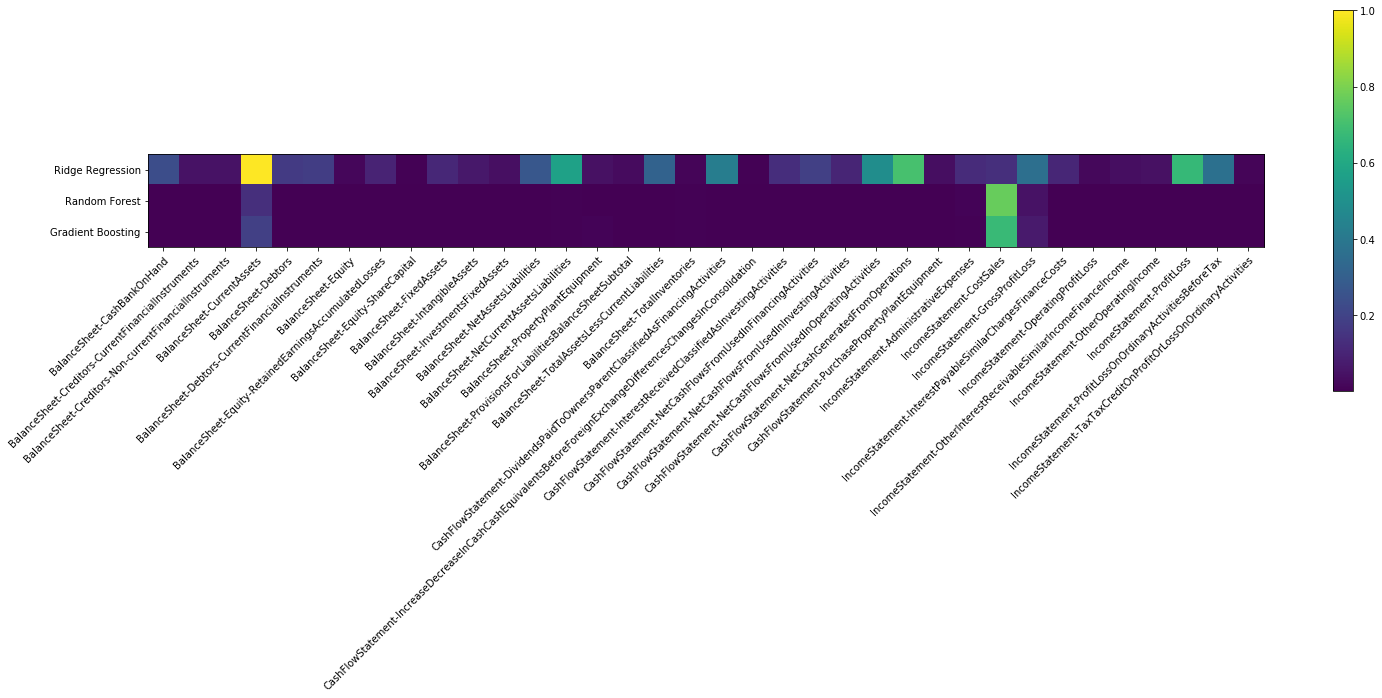

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

models = ["Ridge Regression", "Random Forest", "Gradient Boosting"]
features = list(preprocess_train_data[0].columns)[1:-1]
results = np.stack((np.abs(ridge_mean_coef[0]) / np.abs(ridge_mean_coef[0]).max(), random_forest_mean_coef, gradient_boosting_mean_coef), axis=0)

fig, ax = plt.subplots(figsize=(25, 7))
im = ax.imshow(results)
fig.colorbar(im, orientation='vertical')

# We want to show all ticks...
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(models)))
# ... and label them with the respective list entries
ax.set_xticklabels(features)
ax.set_yticklabels(models)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()
fig.savefig('coef_7_missing_mean.png')

In [0]:
from google.colab import files

files.download('coef_7_missing_mean.png')

# Our Method

## Framework

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [0]:
DATA_INDEX = 4

In [0]:
y_train = preprocess_train_data[DATA_INDEX].loc[:, ['IncomeStatement-TurnoverRevenue']].values
X_train = preprocess_train_data[DATA_INDEX].drop(columns=['IncomeStatement-TurnoverRevenue']).fillna(0).values[:, 1:]
X_train_mask = 1 - preprocess_train_data[DATA_INDEX].drop(columns=['IncomeStatement-TurnoverRevenue']).isna().values[:, 1:]
# X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
# train_data_size, _ = X_train.shape
train_data = [X_train, y_train, X_train_mask]
# train_data = [X_train[:int(0.8*train_data_size)], y_train[:int(0.8*train_data_size)], X_train_mask[:int(0.8*train_data_size)]]
# validate_data = [X_train[int(0.8*train_data_size):], y_train[int(0.8*train_data_size):], X_train_mask[int(0.8*train_data_size):]]

In [0]:
y_test = preprocess_validate_data[DATA_INDEX].loc[:, ['IncomeStatement-TurnoverRevenue']].values
X_test = preprocess_validate_data[DATA_INDEX].drop(columns=['IncomeStatement-TurnoverRevenue']).fillna(0).values[:, 1:]
X_test_mask = 1 - preprocess_validate_data[DATA_INDEX].drop(columns=['IncomeStatement-TurnoverRevenue']).isna().values[:, 1:]
# X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
test_data = [X_test, y_test, X_test_mask]

In [0]:
class Trainer(object):
  
  def __init__(self, train_data, validate_data, models, hyperparams):
    self.train_data = train_data
    self.validate_data = validate_data
    if len(models) == 2:
      self.model = models[0]
      self.regressor = models[1]
    elif len(models) == 1:
      self.model = models[0]
    else:
      raise RuntimeError('Please input at least one model!')
    assert isinstance(hyperparams, dict)
    self.lr = hyperparams.get('lr', 1e-3)
    self.batch_size = hyperparams.get('batch_size', 32)
    self.num_epochs = hyperparams.get('num_epochs', 10)
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    self.aux_flag = hyperparams.get('aux_flag', False)
    
  def shuffle(self, data):
    features, labels, mask = data
    data_size, _ = features.shape
    data_selection = np.random.choice(data_size, data_size)
    new_features = []
    new_labels = []
    new_mask = []
    for i in range(int(data_size/self.batch_size)):
      new_features.append(features[data_selection[i*self.batch_size:(i+1)*self.batch_size], :])
      new_labels.append(labels[data_selection[i*self.batch_size:(i+1)*self.batch_size], :])
      new_mask.append(mask[data_selection[i*self.batch_size:(i+1)*self.batch_size], :])
    return [new_features, new_labels, new_mask]
  
  def process(self):
    self.model.train()
    for epoch in range(self.num_epochs):
      features, labels, mask = self.shuffle(self.train_data)
      features, labels, mask = torch.tensor(features), torch.tensor(labels), torch.tensor(mask)
      num_iters, _, _ = features.shape
      mean_kl_loss = 0
      mean_reconstruction_loss = 0
      if self.aux_flag:
        mean_prediction_loss = 0
      for i in range(num_iters):
        self.optimizer.zero_grad()
        x, x_mask, y = features[i], mask[i], labels[i]
        x_sample, z_mu, z_log_var = self.model(x.float())
        if self.aux_flag:
          y_ = self.regressor(x_sample)
          assert y.size() == y_.size()
          pred_loss = torch.sum((y.float() - y_)**2)
        kl_loss = 0.5 * torch.sum(torch.exp(z_log_var) + z_mu**2 - 1.0 - z_log_var)
        reconstruction_loss = torch.sum((x_sample.float() - x.float())**2 * x_mask.float())
        if not self.aux_flag:
          loss = reconstruction_loss + kl_loss
        else:
          loss = reconstruction_loss + kl_loss + pred_loss
        loss.backward()
        mean_kl_loss += kl_loss.item()
        mean_reconstruction_loss += reconstruction_loss.item()
        if self.aux_flag:
          mean_prediction_loss += pred_loss.item()
        self.optimizer.step()
      mean_kl_loss /= num_iters
      mean_reconstruction_loss /= num_iters
      if self.aux_flag:
        mean_prediction_loss /= num_iters
      if not self.aux_flag:
        print ('This is epoch {:d}, average kl loss is {:4.3f}, average reconstruction loss is {:4.3f}'.format(epoch, mean_kl_loss, mean_reconstruction_loss))
      else:
        print ('This is epoch {:d}, average kl loss is {:4.3f}, average reconstruction loss is {:4.3f}, average pred loss is {:4.3f}'.format(epoch, mean_kl_loss, mean_reconstruction_loss, mean_prediction_loss))

In [0]:
class Encoder(nn.Module):

  def __init__(self, hyperparams):
      super().__init__()
      input_dim = hyperparams.get('input_dim', 36)
      hid_dim = hyperparams.get('hid_dim', 128)
      latent_dim = hyperparams.get('latent_dim', 20)
      self.linear = nn.Linear(input_dim, hid_dim)
      self.mu = nn.Linear(hid_dim, latent_dim)
      self.var = nn.Linear(hid_dim, latent_dim)

  def forward(self, x):
      hid = torch.relu(self.linear(x)) # shape=[batch_size, hidden_dim]
      # latent parameters
      mean = self.mu(hid) # shape=[batch_size, latent_dim]
      log_var = self.var(hid) # shape=[batch_size, latent_dim]
      return mean, log_var


class Decoder(nn.Module):

  def __init__(self, hyperparams):
      super().__init__()
      input_dim = hyperparams.get('input_dim', 36)
      hid_dim = hyperparams.get('hid_dim', 128)
      latent_dim = hyperparams.get('latent_dim', 20)
      self.linear = nn.Linear(latent_dim, hid_dim)
      self.out = nn.Linear(hid_dim, input_dim)

  def forward(self, x):
      hid = torch.relu(self.linear(x)) # shape=[batch_size, hidden_dim]
      # pred = torch.sigmoid(self.out(hid)) # shape=[batch_size, output_dim]
      pred = self.out(hid)
      return pred
      
      
class VAE(nn.Module):

  def __init__(self, enc, dec):
      super().__init__()
      self.enc = enc
      self.dec = dec

  def forward(self, x):
      
      # encoding
      z_mu, z_log_var = self.enc(x) # sample from the distribution having latent parameters z_mu, z_var

      # reparameterization
      std = torch.exp(z_log_var / 2)
      eps = torch.randn_like(std)
      z_sample = eps.mul(std).add_(z_mu)

      # decoding
      x_sample = self.dec(z_sample)
      return x_sample, z_mu, z_log_var
  
  def test(self, x):
      # encoding
      z_mu, z_log_var = self.enc(x) # sample from the distribution having latent parameters z_mu, z_var
      # decoding
      x_sample = self.dec(z_mu)
      return x_sample, z_mu, z_log_var
      
class Regressor(nn.Module):
  
  def __init__(self, hyperparams):
    super().__init__()
    inp_dim = hyperparams.get('input_dim', 36)
    hid_dim = hyperparams.get('hid_dim', 128)
    self.linear = nn.Linear(inp_dim, hid_dim)
    self.out = nn.Linear(hid_dim, 1)
    
  def forward(self, x):
    hid = torch.relu(self.linear(x))
    pred = self.out(hid)
    return pred

## VAE

In [0]:
hyperparams = {'lr': 1e-4,
               'batch_size': 64,
               'num_epochs': 1000,
               'input_dim': 36,
               'hid_dim': 128,
               'latent_dim': 18,
               'aux_flag': False
              }

In [0]:
encoder = Encoder(hyperparams)
decoder = Decoder(hyperparams)
missing_model = VAE(encoder, decoder)
regression_model = Regressor(hyperparams)
trainer = Trainer(train_data, test_data, [missing_model, regression_model], hyperparams)

In [0]:
trainer.process()

This is epoch 0, average kl loss is 35.261, average reconstruction loss is 1674.382
This is epoch 1, average kl loss is 38.812, average reconstruction loss is 2075.097
This is epoch 2, average kl loss is 36.096, average reconstruction loss is 2144.554
This is epoch 3, average kl loss is 32.612, average reconstruction loss is 2164.671
This is epoch 4, average kl loss is 28.651, average reconstruction loss is 1937.403
This is epoch 5, average kl loss is 37.322, average reconstruction loss is 2486.294
This is epoch 6, average kl loss is 29.378, average reconstruction loss is 1951.059
This is epoch 7, average kl loss is 35.250, average reconstruction loss is 2296.420
This is epoch 8, average kl loss is 37.967, average reconstruction loss is 2259.032
This is epoch 9, average kl loss is 31.392, average reconstruction loss is 1645.002
This is epoch 10, average kl loss is 35.237, average reconstruction loss is 1799.097
This is epoch 11, average kl loss is 39.212, average reconstruction loss is

In [0]:
X_train_vae, _, _ = missing_model.test(torch.tensor(train_data[0]).float())
X_train_vae = X_train_vae.detach().numpy()
y_train_vae = train_data[1]
train_vae = [X_train_vae, y_train_vae]
# X_validate_imp, _, _ = missing_model(torch.tensor(validate_data[0]).float())
# X_val_imp = X_validate_imp.detach().numpy()
# y_val = validate_data[1]
X_test_vae, _, _ = missing_model.test(torch.tensor(test_data[0]).float())
X_test_vae = X_test_vae.detach().numpy()
y_test_vae = test_data[1]
length, _ = X_test_vae.shape
test_vae = [X_test_vae[:int(0.8*length)], y_test_vae[:int(0.8*length)]]

In [0]:
X_test_vae.shape

(275, 36)

### Ridge Regression

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('ridge_regression')
trainig_results = pred_model.params_tuning(hyperparams={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]}, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.76369e-08): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.86892e-08): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.29032e-08): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.75947e-09): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.31633e-08): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: Deprec

In [0]:
trainig_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007011,0.003880,0.000932,0.000060,1e-05,{'alpha': 1e-05},-6.616643,-3.525244,-1.430599e+11,0.160958,-21773.605958,-2.859726e+10,5.721291e+10,2
1,0.005138,0.001241,0.000956,0.000138,0.0001,{'alpha': 0.0001},-6.693354,-3.569991,-1.428584e+11,0.155999,-21841.272484,-2.855699e+10,5.713234e+10,1
2,0.005155,0.001444,0.000887,0.000010,0.001,{'alpha': 0.001},-7.388982,-3.252215,-1.439441e+11,0.126228,-22607.672201,-2.877402e+10,5.756654e+10,3
3,0.003184,0.001291,0.000892,0.000010,0.01,{'alpha': 0.01},-1108.632759,-2.295145,-1.307592e+13,0.081588,-191248.464881,-2.613839e+12,5.229360e+12,6
4,0.002288,0.000030,0.000893,0.000025,0.1,{'alpha': 0.1},-30.946751,-1.753893,-2.043249e+11,0.025261,-18667.243577,-4.084396e+10,8.171418e+10,4
5,0.002277,0.000018,0.000878,0.000008,1,{'alpha': 1.0},-19.876453,-1.402849,-2.256719e+11,-0.016077,-3513.925563,-4.511116e+10,9.025134e+10,5


In [0]:
trainig_results.to_csv('ridge_missing_11_vae_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('ridge_missing_11_vae_cv.csv')

In [0]:
pred_model.test(hyperparams={})

-158.53558234226585

In [0]:
ridge_mean_coef = pred_model.params_tuner.best_estimator_.coef_

### SVR

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('svr')
pred_model.params_tuning(hyperparams={'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
                                      'kernel': ['linear', 'rbf', 'sigmoid']
                                     }, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.198292,0.006758,0.030055,0.001409,1e-05,linear,"{'C': 1e-05, 'kernel': 'linear'}",-0.068170,-0.029412,-0.041702,-0.093705,-0.066017,-0.059801,0.022402,9
1,0.321027,0.003135,0.051481,0.002292,1e-05,rbf,"{'C': 1e-05, 'kernel': 'rbf'}",-0.072603,-0.031270,-0.046866,-0.097795,-0.063364,-0.062380,0.022664,12
2,0.278832,0.004084,0.043569,0.000782,1e-05,sigmoid,"{'C': 1e-05, 'kernel': 'sigmoid'}",-0.072608,-0.031320,-0.046855,-0.097857,-0.063319,-0.062392,0.022671,13
3,0.192683,0.004166,0.030335,0.001253,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",-0.038065,-0.010432,-0.012405,-0.068012,-0.088581,-0.043499,0.030735,6
4,0.319199,0.007183,0.050717,0.000589,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",-0.071470,-0.030268,-0.045534,-0.096634,-0.062174,-0.061216,0.022646,10
5,0.288237,0.009152,0.044045,0.001493,0.0001,sigmoid,"{'C': 0.0001, 'kernel': 'sigmoid'}",-0.071519,-0.030717,-0.045741,-0.096808,-0.062950,-0.061547,0.022562,11
6,0.207877,0.001356,0.031618,0.000528,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.090610,0.066888,0.077975,0.052314,-0.384467,-0.019336,0.183001,5
7,0.306626,0.009652,0.049138,0.002368,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",-0.061210,-0.020656,-0.033903,-0.083208,-0.052257,-0.050247,0.021695,7
8,0.290344,0.010980,0.044686,0.001918,0.001,sigmoid,"{'C': 0.001, 'kernel': 'sigmoid'}",-0.061701,-0.025779,-0.036250,-0.088754,-0.064231,-0.055343,0.022245,8
9,0.196167,0.004248,0.029965,0.000809,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.157120,0.146767,0.095396,0.203439,-2.009704,-0.281396,0.864836,15


In [0]:
pred_model.test(hyperparams={})

0.3696003144567541

### Random Forest

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('random_forest')
trainig_results = pred_model.params_tuning(hyperparams={'n_estimators': [10, 20, 40, 80]}, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

In [0]:
trainig_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.174968,0.021334,0.001608,0.000036,10,{'n_estimators': 10},-0.001288,-0.315197,-2.853788e+12,-0.406956,-375.911564,-5.704638e+11,1.141295e+12,4
1,0.349194,0.039580,0.002200,0.000059,20,{'n_estimators': 20},-0.136503,-0.489959,-1.427023e+12,-0.399442,-818.304081,-2.852578e+11,5.706990e+11,3
2,0.655688,0.067180,0.003278,0.000056,40,{'n_estimators': 40},-0.909168,-0.430352,-3.567558e+11,-0.292252,-951.806401,-7.131445e+10,1.426748e+11,2
3,1.341306,0.151358,0.005804,0.000290,80,{'n_estimators': 80},-1.085408,-0.445212,-1.224058e+11,-0.241673,-765.643401,-2.446856e+10,4.895286e+10,1


In [0]:
trainig_results.to_csv('random_forest_missing_9_vae_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('random_forest_missing_9_vae_cv.csv')

In [0]:
pred_model.test(hyperparams={})

-1123.1492391806555

In [0]:
random_forest_mean_coef = pred_model.params_tuner.best_estimator_.feature_importances_

### Gradient Boosting

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('gradient_boosting')
training_results = pred_model.params_tuning(hyperparams={'n_estimators': [10, 20, 40, 80],
                                                        'max_depth': [5, 10, 15, 20]
                                                       }, 
                                           cv=5
                                          )

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [0]:
training_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048484,0.000898,0.000796,0.000030,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.578602,0.561015,0.599311,0.578239,0.705343,0.604502,0.051860,16
1,0.092312,0.001784,0.000932,0.000013,5,20,"{'max_depth': 5, 'n_estimators': 20}",0.663829,0.660232,0.717431,0.653571,0.749293,0.688871,0.037842,12
2,0.179239,0.001619,0.001137,0.000029,5,40,"{'max_depth': 5, 'n_estimators': 40}",0.687460,0.688583,0.771459,0.696216,0.750729,0.718889,0.035207,2
3,0.357490,0.003256,0.001617,0.000190,5,80,"{'max_depth': 5, 'n_estimators': 80}",0.685043,0.704198,0.768675,0.711406,0.755199,0.724904,0.031729,1
4,0.121646,0.001428,0.001087,0.000053,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.558850,0.556355,0.615000,0.575621,0.758221,0.612809,0.075671,15
5,0.229854,0.007458,0.001291,0.000017,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.639016,0.634107,0.710771,0.658192,0.806147,0.689647,0.064274,11
6,0.418994,0.004545,0.001710,0.000068,10,40,"{'max_depth': 10, 'n_estimators': 40}",0.665905,0.678860,0.745475,0.672488,0.766965,0.705938,0.041814,6
7,0.820847,0.009820,0.002686,0.000149,10,80,"{'max_depth': 10, 'n_estimators': 80}",0.670240,0.680121,0.746424,0.683816,0.762952,0.708711,0.038162,5
8,0.197524,0.002755,0.001331,0.000296,15,10,"{'max_depth': 15, 'n_estimators': 10}",0.592717,0.531357,0.639770,0.608995,0.756740,0.625916,0.074346,13
9,0.376598,0.003150,0.001599,0.000070,15,20,"{'max_depth': 15, 'n_estimators': 20}",0.681587,0.626041,0.725938,0.679786,0.791621,0.700995,0.055281,7


In [0]:
training_results.to_csv('boosting_missing_7_vae_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('boosting_missing_7_vae_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.6617329351900194

In [0]:
gradient_boosting_mean_coef = pred_model.params_tuner.best_estimator_.feature_importances_

### Plot

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

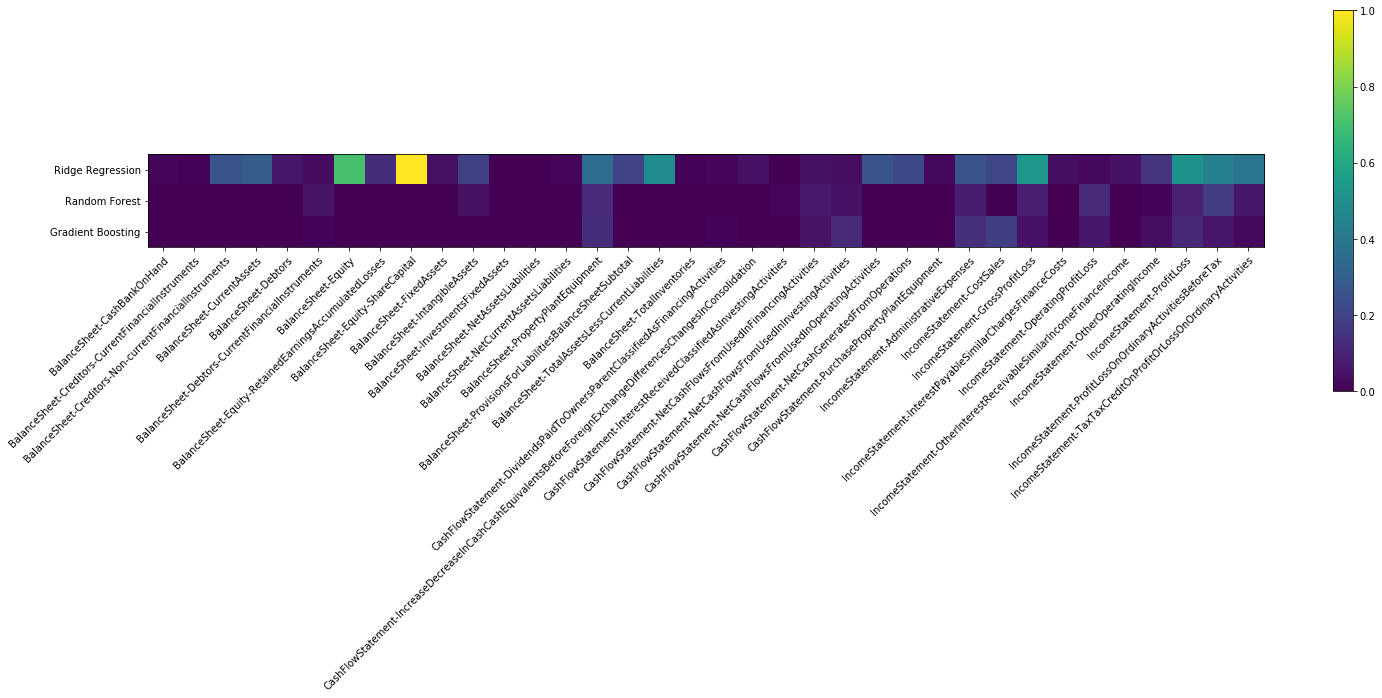

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

models = ["Ridge Regression", "Random Forest", "Gradient Boosting"]
features = list(preprocess_train_data[0].columns)[1:-1]
results = np.stack((np.abs(ridge_mean_coef[0]) / np.abs(ridge_mean_coef[0]).max(), random_forest_mean_coef, gradient_boosting_mean_coef), axis=0)

fig, ax = plt.subplots(figsize=(25, 7))
im = ax.imshow(results)
fig.colorbar(im, orientation='vertical')

# We want to show all ticks...
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(models)))
# ... and label them with the respective list entries
ax.set_xticklabels(features)
ax.set_yticklabels(models)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()
fig.savefig('coef_11_missing_vae.png')

In [0]:
from google.colab import files

files.download('coef_11_missing_vae.png')

## VAE with Auxilliary Prediction

In [0]:
hyperparams = {'lr': 1e-4,
               'batch_size': 64,
               'num_epochs': 1000,
               'input_dim': 36,
               'hid_dim': 128,
               'latent_dim': 18,
               'aux_flag': True
              }

In [0]:
encoder = Encoder(hyperparams)
decoder = Decoder(hyperparams)
missing_model = VAE(encoder, decoder)
regression_model = Regressor(hyperparams)
trainer = Trainer(train_data, test_data, [missing_model, regression_model], hyperparams)

In [0]:
trainer.process()

This is epoch 0, average kl loss is 46.984, average reconstruction loss is 2307.627, average pred loss is 51.846
This is epoch 1, average kl loss is 34.969, average reconstruction loss is 1886.373, average pred loss is 50.527
This is epoch 2, average kl loss is 33.484, average reconstruction loss is 1943.677, average pred loss is 70.292
This is epoch 3, average kl loss is 27.852, average reconstruction loss is 1664.111, average pred loss is 42.897
This is epoch 4, average kl loss is 27.165, average reconstruction loss is 1711.818, average pred loss is 66.165
This is epoch 5, average kl loss is 27.130, average reconstruction loss is 1677.138, average pred loss is 57.226
This is epoch 6, average kl loss is 34.227, average reconstruction loss is 2157.984, average pred loss is 63.292
This is epoch 7, average kl loss is 30.307, average reconstruction loss is 1922.542, average pred loss is 63.551
This is epoch 8, average kl loss is 35.384, average reconstruction loss is 2275.306, average pre

In [0]:
X_train_vae, _, _ = missing_model.test(torch.tensor(train_data[0]).float())
X_train_vae = X_train_vae.detach().numpy()
y_train_vae = train_data[1]
train_vae = [X_train_vae, y_train_vae]
# X_validate_imp, _, _ = missing_model(torch.tensor(validate_data[0]).float())
# X_val_imp = X_validate_imp.detach().numpy()
# y_val = validate_data[1]
X_test_vae, _, _ = missing_model.test(torch.tensor(test_data[0]).float())
X_test_vae = X_test_vae.detach().numpy()
y_test_vae = test_data[1]
length, _ = X_test_vae.shape
test_vae = [X_test_vae[:int(0.8*length)], y_test_vae[:int(0.8*length)]]

### Ridge Regression

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('ridge_regression')
training_results = pred_model.params_tuning(hyperparams={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]}, cv=5)

In [0]:
training_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008883,0.014885,0.000874,0.000081,1e-05,{'alpha': 1e-05},0.552175,0.595092,-0.832458,0.555570,0.507993,0.275674,0.554752,4
1,0.001974,0.001048,0.000865,0.000032,0.0001,{'alpha': 0.0001},0.552152,0.595132,-0.832434,0.555674,0.508003,0.275705,0.554756,3
2,0.001392,0.000022,0.000814,0.000010,0.001,{'alpha': 0.001},0.552007,0.595303,-0.832549,0.556005,0.508097,0.275773,0.554849,2
3,0.001400,0.000035,0.000881,0.000088,0.01,{'alpha': 0.01},0.550344,0.597820,-0.834198,0.559915,0.509351,0.276646,0.556135,1
4,0.001523,0.000092,0.000841,0.000015,0.1,{'alpha': 0.1},0.532298,0.612144,-0.852691,0.580963,0.501317,0.274807,0.565047,5
5,0.001422,0.000045,0.000856,0.000031,1,{'alpha': 1.0},0.452671,0.615016,-0.885461,0.577624,0.390528,0.230076,0.563681,6


In [0]:
training_results.to_csv('ridge_missing_11_vae_pred_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('ridge_missing_11_vae_pred_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.5919956476884196

In [0]:
ridge_mean_coef = pred_model.params_tuner.best_estimator_.coef_

### SVR

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('svr')
pred_model.params_tuning(hyperparams={'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
                                      'kernel': ['linear', 'rbf', 'sigmoid']
                                     }, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.216231,0.005346,0.032051,0.000528,1e-05,linear,"{'C': 1e-05, 'kernel': 'linear'}",-0.055752,-0.017160,-0.029998,-0.081919,-0.053192,-0.047604,0.022414,10
1,0.327437,0.002951,0.051191,0.000614,1e-05,rbf,"{'C': 1e-05, 'kernel': 'rbf'}",-0.072409,-0.031001,-0.046637,-0.097574,-0.063196,-0.062164,0.022681,14
2,0.302729,0.004732,0.046924,0.001647,1e-05,sigmoid,"{'C': 1e-05, 'kernel': 'sigmoid'}",-0.072386,-0.031035,-0.046630,-0.097619,-0.063115,-0.062157,0.022684,13
3,0.212021,0.004976,0.032528,0.001031,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.063813,0.092568,0.075127,0.020343,0.003400,0.051050,0.033704,7
4,0.326145,0.001312,0.051167,0.000496,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",-0.069536,-0.027885,-0.043259,-0.094385,-0.060658,-0.059145,0.022723,11
5,0.308115,0.002267,0.048359,0.001093,0.0001,sigmoid,"{'C': 0.0001, 'kernel': 'sigmoid'}",-0.069305,-0.028235,-0.043167,-0.094613,-0.061179,-0.059300,0.022698,12
6,0.207716,0.005162,0.030638,0.000510,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.293095,0.298263,0.163316,0.221968,-0.039594,0.187410,0.123906,4
7,0.325174,0.002357,0.050796,0.000421,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",-0.042493,0.001730,-0.014470,-0.064512,-0.038940,-0.031737,0.023065,8
8,0.309297,0.003086,0.047948,0.000328,0.001,sigmoid,"{'C': 0.001, 'kernel': 'sigmoid'}",-0.040248,-0.001069,-0.013114,-0.066932,-0.043894,-0.033051,0.023399,9
9,0.229099,0.008205,0.032908,0.001629,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.542021,0.512690,-0.109239,0.384535,0.173111,0.300624,0.242707,3


In [0]:
pred_model.test(hyperparams={})

0.6868362288844772

### Random Forest

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('random_forest')
training_results = pred_model.params_tuning(hyperparams={'n_estimators': [10, 20, 40, 80]}, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

In [0]:
training_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.219504,0.002761,0.002259,0.000203,10,{'n_estimators': 10},0.724427,0.792503,0.724752,0.700211,0.810008,0.750380,0.042842,4
1,0.435885,0.007162,0.003245,0.000171,20,{'n_estimators': 20},0.767431,0.794661,0.734008,0.733259,0.820753,0.770022,0.034164,1
2,0.859048,0.008921,0.005429,0.000234,40,{'n_estimators': 40},0.741771,0.784263,0.747628,0.733526,0.822716,0.765981,0.033254,3
3,1.723165,0.016645,0.009800,0.000209,80,{'n_estimators': 80},0.745933,0.783201,0.760613,0.739229,0.817861,0.769368,0.028556,2


In [0]:
training_results.to_csv('random_forest_missing_11_vae_pred_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('random_forest_missing_11_vae_pred_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.6957585053522314

In [0]:
random_forest_mean_coef = pred_model.params_tuner.best_estimator_.feature_importances_

### Gradient Boosting

In [0]:
pred_model = Prediction_Models(train_vae, test_vae)
pred_model('gradient_boosting')
trainig_results = pred_model.params_tuning(hyperparams={'n_estimators': [10, 20, 40, 80],
                                                        'max_depth': [5, 10, 15, 20]
                                                       }, 
                                           cv=5
                                          )

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [0]:
trainig_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.050655,0.002717,0.000847,0.000019,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.672743,0.597001,0.605150,0.620023,0.657350,0.630453,0.029597,16
1,0.095374,0.001621,0.001002,0.000112,5,20,"{'max_depth': 5, 'n_estimators': 20}",0.774980,0.706253,0.731699,0.698471,0.774840,0.737249,0.032656,12
2,0.184162,0.001928,0.001199,0.000092,5,40,"{'max_depth': 5, 'n_estimators': 40}",0.797871,0.743664,0.781996,0.725317,0.802326,0.770235,0.030514,6
3,0.364883,0.002654,0.001610,0.000102,5,80,"{'max_depth': 5, 'n_estimators': 80}",0.802437,0.747497,0.782912,0.743172,0.799867,0.775177,0.025310,3
4,0.131864,0.002532,0.001113,0.000073,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.676012,0.638661,0.668030,0.651044,0.665982,0.659946,0.013358,13
5,0.240975,0.008082,0.001434,0.000087,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.753256,0.736456,0.749546,0.723985,0.781178,0.748884,0.019167,9
6,0.439206,0.008604,0.001884,0.000070,10,40,"{'max_depth': 10, 'n_estimators': 40}",0.775161,0.771519,0.785570,0.741535,0.795368,0.773831,0.018176,5
7,0.847072,0.016057,0.002729,0.000086,10,80,"{'max_depth': 10, 'n_estimators': 80}",0.777956,0.774291,0.784669,0.743863,0.795001,0.775156,0.017159,4
8,0.203272,0.002588,0.001387,0.000257,15,10,"{'max_depth': 15, 'n_estimators': 10}",0.657449,0.620185,0.632207,0.637260,0.672163,0.643853,0.018577,15
9,0.390740,0.004158,0.001624,0.000117,15,20,"{'max_depth': 15, 'n_estimators': 20}",0.737104,0.726113,0.726966,0.721022,0.783470,0.738935,0.022870,11


In [0]:
training_results.to_csv('boosting_missing_11_vae_pred_cv.csv', index=False)

In [0]:
from google.colab import files

files.download('boosting_missing_11_vae_pred_cv.csv')

In [0]:
pred_model.test(hyperparams={})

0.7011381773981193

In [0]:
gradient_boosting_mean_coef = pred_model.params_tuner.best_estimator_.feature_importances_

###Plot

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

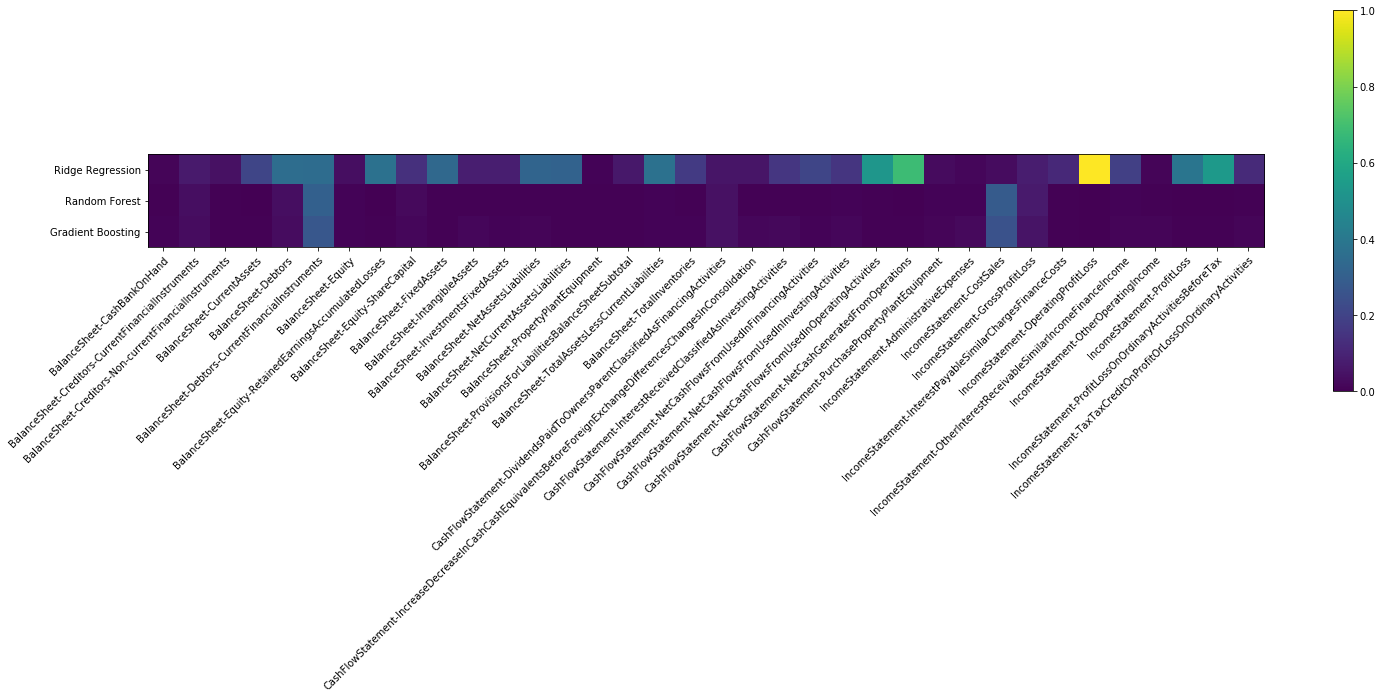

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

models = ["Ridge Regression", "Random Forest", "Gradient Boosting"]
features = list(preprocess_train_data[0].columns)[1:-1]
results = np.stack((np.abs(ridge_mean_coef[0])/np.abs(ridge_mean_coef[0]).max(), random_forest_mean_coef, gradient_boosting_mean_coef), axis=0)

fig, ax = plt.subplots(figsize=(25, 7))
im = ax.imshow(results, vmin=0, vmax=1)
fig.colorbar(im, orientation='vertical')

# We want to show all ticks...
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(models)))
# ... and label them with the respective list entries
ax.set_xticklabels(features)
ax.set_yticklabels(models)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()
fig.savefig('coef_7_missing_vae_pred.png')

In [0]:
from google.colab import files

files.download('coef_7_missing_vae_pred.png')